# Field data from Bennet's and Jimmy's Beach

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import oceanlyz
from matplotlib.pyplot import cm
from scipy.ndimage.filters import gaussian_filter1d

In [195]:
#Import the csv's we created in the previous notebook:
pdbennets = pd.read_csv('bennet_wavedata.csv')
pdjimmys = pd.read_csv('jimmys_wavedata.csv')

In [217]:
print('Data types: ')
print(pdbennets.dtypes)

print('Data length: ' +str(len(pdbennets)))



pdbennets.head()

Data types: 
Time            datetime64[ns]
Pressure               float64
Sea pressure           float64
Depth                  float64
dtype: object
Data length: 191250


,Time,Pressure,Sea pressure,Depth
0,2023-03-11 08:28:38.750,11.259309,1.126809,1.117620
1,2023-03-11 08:28:38.875,11.287429,1.154929,1.145511
2,2023-03-11 08:28:39.000,11.303289,1.170789,1.161242
3,2023-03-11 08:28:39.125,11.306530,1.174030,1.164456
4,2023-03-11 08:28:39.250,11.299992,1.167492,1.157972


Take a quick look at the raw data.

It may take some time. See how many data points we have in the output above. 

<AxesSubplot:xlabel='Time'>

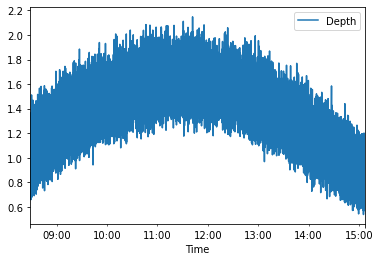

In [218]:
pdbennets.plot('Time', 'Depth')

<AxesSubplot:xlabel='Time'>

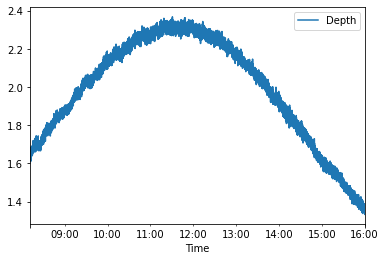

In [221]:
pdjimmys.plot('Time', 'Depth')

In [220]:
#Convert to datetime again
pdbennets['Time'] = pd.to_datetime(pdbennets['Time'])
pdjimmys['Time'] = pd.to_datetime(pdjimmys['Time'])
print('Data types: ')
print(pdbennets.dtypes)

Data types: 
Time            datetime64[ns]
Pressure               float64
Sea pressure           float64
Depth                  float64
dtype: object


In [198]:
def get_bursts(data):
    Hz=8  
    bl=30*60  #burst length 5min x 60sec
    nbl = int(np.floor(len(data)/(bl*Hz)))
   
    print('Number of bursts is %s and burst duration is %s seconds' %(nbl, bl))
    if nbl>1000:
        print('WARNING:')
        print('Oceanlyz has a limit of 900 bursts. Try cut the data and analyse separately')
        print('Try cutting the data into %s'%(nbl/900))
    print('')    
    print('Sensor start:')
    print(np.min(data.Time))
    print('Sensor finish:')
    print(np.max(data.Time))
    print('Total duration: ')
    td=np.max(data.Time)-np.min(data.Time)
    mins = td.days*24*60 + td.seconds/60
    print('%s mins' %(mins))
    
    return bl, nbl
bl, nbl = get_bursts(pdbennets)

Number of bursts is 13 and burst duration is 1800 seconds

Sensor start:
2023-03-11 08:28:38.750000
Sensor finish:
2023-03-11 15:07:04.875000
Total duration: 
398.43333333333334 mins


In [199]:
#Here we set up the oceanlyz parameters. 
def run_oceanlyz(data):
    #start Oceanlyz 
    ocn = oceanlyz.oceanlyz()
    ocn.data = data['Pressure'] * 10000 #Convert dbar to pa
    
    #set up oceanlyz parameters:
    ocn.InputType='pressure'
    ocn.OutputType='wave+waterlevel'
    ocn.AnalysisMethod='spectral'      #We can also select a 'zero-crossing' method of wave analysis
    ocn.n_burst=nbl
    ocn.burst_duration=bl
    ocn.fs=8                            #Samples are at 8 Hz
    ocn.SeparateSeaSwell='yes'
    ocn.seaswellCalc='on'
    ocn.fmin=0.03
    ocn.fmax=ocn.fs/2                  #should be between 0 and (fs/2) - It is a simple low pass filter
    ocn.fmaxpcorrCalcMethod='auto'     #Only required if ocn.InputType='pressure'
    ocn.Kpafterfmaxpcorr='constant'    #Only required if ocn.InputType='pressure'
    ocn.fminpcorr=0.03                 #Only required if ocn.InputType='pressure'
    ocn.fmaxpcorr=ocn.fs/2             #Only required if ocn.InputType='pressure'
    ocn.heightfrombed=0.10             #Only required if ocn.InputType='pressure'
    ocn.dispout='no'
    ocn.Rho=1024                     #Seawater density (Varies)
    
    #Run onceanlyz:
    ocn.runoceanlyz()
    return ocn.wave

In [200]:
ben_waves = run_oceanlyz(pdbennets)

--------------------------------------------------
OCEANLYZ Ver 2.0
www.ArashKarimpour.com
Copyright (C) 2012 - 2023  Arash Karimpour
--------------------------------------------------
Parameters (only required ones used)
--------------------------------------------------
InputType           :  pressure
OutputType          :  wave+waterlevel
-------------------------------
AnalysisMethod      :  spectral
-------------------------------
n_burst             :  13
burst_duration      :  1800
fs                  :  8
-------------------------------
fmin                :  0.03
fmax                :  4.0
-------------------------------
fmaxpcorrCalcMethod :  auto
Kpafterfmaxpcorr    :  constant
fminpcorr           :  0.03
fmaxpcorr           :  4.0
heightfrombed       :  0.1
-------------------------------
dispout             :  no
-------------------------------
Rho                 :  1024
nfft                :  512
-------------------------------
SeparateSeaSwell    :  yes
fpminswell      

In [201]:
jim_waves = run_oceanlyz(pdjimmys)

--------------------------------------------------
OCEANLYZ Ver 2.0
www.ArashKarimpour.com
Copyright (C) 2012 - 2023  Arash Karimpour
--------------------------------------------------
Parameters (only required ones used)
--------------------------------------------------
InputType           :  pressure
OutputType          :  wave+waterlevel
-------------------------------
AnalysisMethod      :  spectral
-------------------------------
n_burst             :  13
burst_duration      :  1800
fs                  :  8
-------------------------------
fmin                :  0.03
fmax                :  4.0
-------------------------------
fmaxpcorrCalcMethod :  auto
Kpafterfmaxpcorr    :  constant
fminpcorr           :  0.03
fmaxpcorr           :  4.0
heightfrombed       :  0.1
-------------------------------
dispout             :  no
-------------------------------
Rho                 :  1024
nfft                :  512
-------------------------------
SeparateSeaSwell    :  yes
fpminswell      

In [202]:
def plot_ocn_waves(data, title='title', save = False):

    fig = plt.figure(figsize=(10,6), dpi=100) 
    ax =plt.gca()

    plt.plot(data['Hm0'], c ='black')
    plt.plot(data['Hm0sea'], c = 'b', label = 'Wind waves')
    plt.plot(data['Hm0swell'], c = 'r', label = 'Swell waves')

    plt.xlabel('Burst Number')
    plt.ylabel('Hm0 (m)')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    #gaussian_filter1d(data, sigma=2)
    
    #plt.xlim(0,140)
    #plt.ylim(0.1,0.3)

    plt.title('%s Hs Waves'%(title))
    ax.set_ylabel('Hs (m)',fontsize=10)
    ax.set_xlabel('Burst Number',fontsize=10)

    plt.grid()
    plt.legend(loc=0, frameon=True)
    plt.show()
    

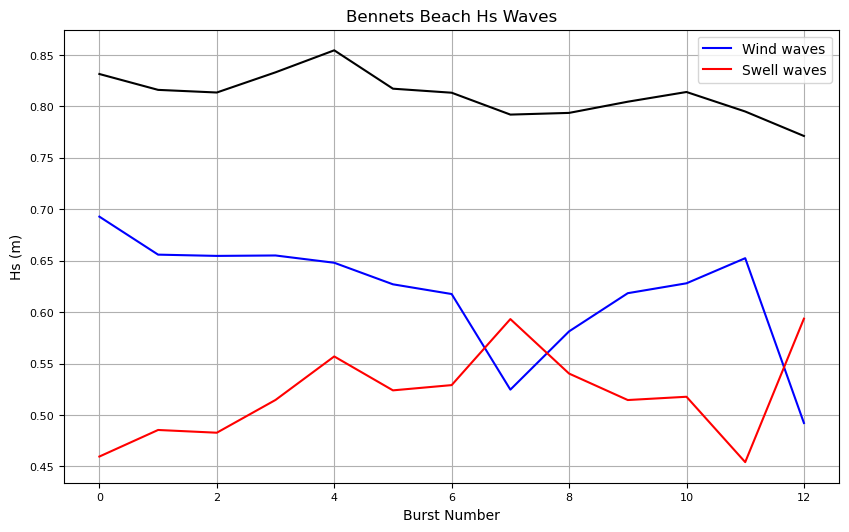

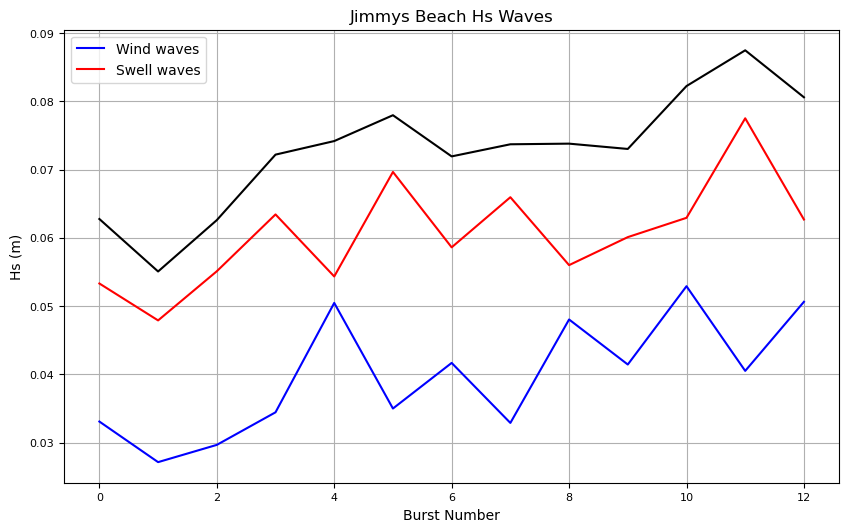

In [203]:
plot_ocn_waves(ben_waves, title = 'Bennets Beach')
plot_ocn_waves(jim_waves, title = 'Jimmys Beach')

In [204]:
#Print wave data
print('Max wave height at Bennets Beach: ')
print(ben_waves['Hm0'].max())

print('Mean wave period at Bennets Beach: ')
print(ben_waves['Tp'].mean())

print('Max wave height at Jimmys Beach: ')
print(jim_waves['Hm0'].max())

print('Mean wave period at Jimmys Beach: ')
print(jim_waves['Tp'].mean())


Max wave height at Bennets Beach: 
0.8544659762960533
Mean wave period at Bennets Beach: 
9.100233100233101
Max wave height at Jimmys Beach: 
0.087461707297737
Mean wave period at Jimmys Beach: 
10.666666666666666


Look at other outputs by copying the lines above. Try looking at min/mean/max of the following fields:

In [205]:
ben_waves['Field_Names']

['Eta, Hm0, Hm0sea, Hm0swell, Tp, Tpsea, Tpswell, fp, fseparation, f, Syy, Field_Names, Burst_Data']

In [206]:
#Lets set up a function to plot the data
def plot_spectral(data, title = 'title'):    
    f = data['f'] #frequency of the first burst
    Syy = data['Syy'] #spectrum of the first burst
    fig, ax = plt.subplots(figsize = (8,8))
    ax.plot(f[0,:],Syy[0,:], color='k')
    
    ax.set_xlabel('f (Hz)')
    ax.set_ylabel('Syy (m^2/Hz)')
    ax.set_xlim(0,0.6)
    ax.set_title(title)
    plt.show()
    

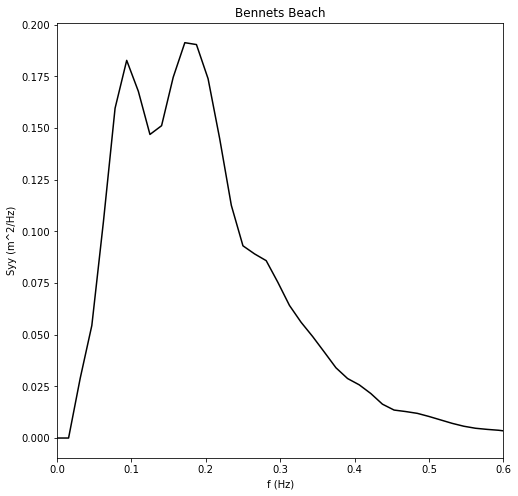

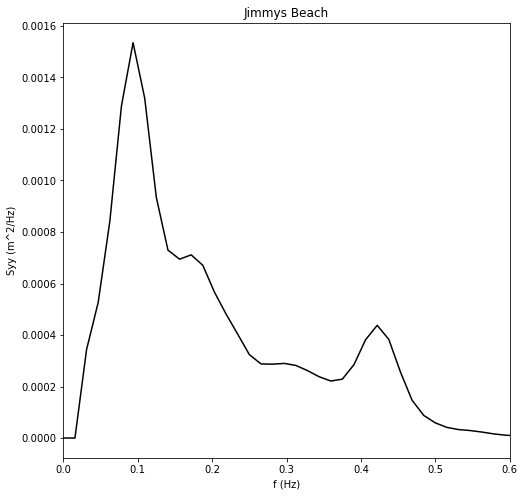

In [207]:
plot_spectral(ben_waves, 'Bennets Beach')
plot_spectral(jim_waves, 'Jimmys Beach')

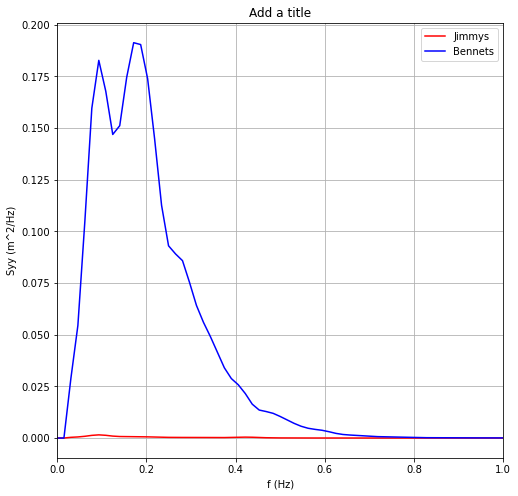

In [208]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(jim_waves['f'][0,:],jim_waves['Syy'][0,:], color='r', label = 'Jimmys')
ax.plot(ben_waves['f'][0,:],ben_waves['Syy'][0,:], color='b', label = 'Bennets')
ax.set_xlabel('f (Hz)')
ax.set_ylabel('Syy (m^2/Hz)')
ax.set_xlim(0,0.6)
ax.set_title('Add a title')   
ax.set_xlim(0,1)
ax.grid()
ax.legend()